In [19]:
import cv2
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.metrics import accuracy_score

In [20]:
def preprocess(images, threshold=120, kernel=np.ones((3, 3), np.uint8)):
    """Preprocess the fingerprint images"""

    processed = []
    for image in images:
        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Convert the image to a binary image
        _, binarized = cv2.threshold(image, threshold, maxval=255, type=cv2.THRESH_BINARY)

        # Apply closing on the binarized image
        closed = cv2.morphologyEx(binarized, cv2.MORPH_CLOSE, kernel)

        processed.append(closed)

    return processed

def extract_edges(images):
    """Extract edges from the fingerprint images"""

    edges = []
    for image in images:
        edges.append(cv2.Canny(image, 100, 200))

    return edges


class PrintClassifier:
    def __init__(self):
        self.train_features = []
        self.class_labels = []

    def preprocess(self, fingerprint):
        """Preprocess a single fingerprint image"""

        # Convert the fingerprint to binary image
        _, fingerprint = cv2.threshold(fingerprint, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # Perform opening operation to remove small noise
        kernel = np.ones((3, 3), np.uint8)
        fingerprint = cv2.morphologyEx(fingerprint, cv2.MORPH_OPEN, kernel)

        # Perform closing operation to fill small gaps and holes
        fingerprint = cv2.morphologyEx(fingerprint, cv2.MORPH_CLOSE, kernel)

        # Perform dilation operation to increase the size of ridges
        fingerprint = cv2.dilate(fingerprint, kernel, iterations=1)

        return fingerprint

    def train(self, fingerprints, class_labels_list):
        """Train the classifier"""

        for i, fingerprint in enumerate(fingerprints):
            # Preprocess the fingerprint
            fingerprint = self.preprocess(fingerprint)

            # Compute the HOG features of the fingerprint
            _, hog_features = hog(fingerprint, orientations=8, pixels_per_cell=(16, 16),
                                  cells_per_block=(1, 1), visualize=True)

            # Add the HOG features and the class label to the training data
            self.train_features.append(hog_features)
            self.class_labels.append(class_labels_list[i])

    def classify(self, new_fingerprints):
        """Classify new fingerprints"""
        classifications = []

        for new_fingerprint in new_fingerprints:
            # Preprocess the new fingerprint
            new_fingerprint = self.preprocess(new_fingerprint)

            # Compute the HOG features of the new fingerprint
            _, new_hog_features = hog(new_fingerprint, orientations=8, pixels_per_cell=(16, 16),
                                      cells_per_block=(1, 1), visualize=True)

            # Compute the similarity between the new HOG features and the training HOG features
            similarities = []
            for sample_feat in self.train_features:
                similarity = np.sum(np.abs(sample_feat - new_hog_features))
                similarities.append(similarity)

            # Classify the new fingerprint based on the most similar training fingerprint
            classifications.append(self.class_labels[np.argmin(similarities)])

        return classifications

In [21]:
# Load the fingerprint images and their corresponding labels
url = "png_txt"
images = glob.glob(url + '/**/*.png', recursive=True)
info = glob.glob(url + '/**/*.txt', recursive=True)

# Extract the labels from the text files```python
def extract_label(file_name):
    """Extract the class label from a text file"""
    with open(file_name, "r") as file:
        contents = file.read()
        pattern = r"Class:\s+(\w)"
        match = re.findall(pattern, contents)
    return match[0]

In [22]:
# Extract the labels from the text files
images_list_train = []
labels_list_train = []
images_list_test = []
labels_list_test = []

for i, img in enumerate(images):
    if i < 800:
        images_list_train.append(cv2.imread(img, cv2.IMREAD_GRAYSCALE))
        labels_list_train.append(extract_label(info[i]))
    elif i < 1000:
        images_list_test.append(cv2.imread(img, cv2.IMREAD_GRAYSCALE))
        labels_list_test.append(extract_label(info[i]))
    else:
        break

In [23]:
# Train the classifier
pc = PrintClassifier()
pc.train(images_list_train, labels_list_train)

# Classify the test images and compute the accuracy of the classifier
labels_pred = pc.classify(images_list_test)
accuracy = accuracy_score(labels_list_test, labels_pred)
print(f"The accuracy of the classifier is: {accuracy}")

The accuracy of the classifier is: 0.255


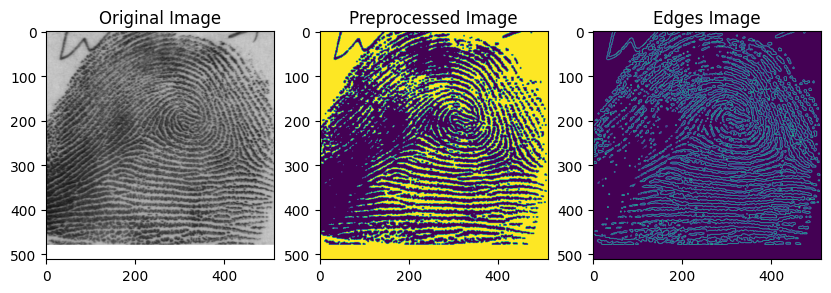

In [24]:
# Load the image
img = cv2.imread(images[0])

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Show the original image in the first subplot
axs[0].imshow(img)
axs[0].set_title('Original Image')

# Preprocess the image and show it in the second subplot
preprocessed_img = preprocess([img])[0]
axs[1].imshow(preprocessed_img)
axs[1].set_title('Preprocessed Image')

# Extract edges from the preprocessed image and show them in the third subplot
edges_img = extract_edges([preprocessed_img])[0]
axs[2].imshow(edges_img)
axs[2].set_title('Edges Image')

# Show the plots
plt.show()